In [1]:
# In order to import from the python file without hassle, we add the current
# directory to the python path
import sys; sys.path.append(".")

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import openTSNE
import matplotlib.pyplot as plt

import helper_functions

# Gene-expression data

In this homework, we will look at how to analyse gene-expression data. We will be working with single-cell data, where we have measurements for individual cells. Briefly, single cell-sequencing captures mRNA molecules from a sample of cells. These mRNA molecules are mapped to the genome to determine which gene each mRNA molecule belongs to (using approaches based on local alignment, which we learned about homework 2). For every molecule, we also know which cell it came from. So, putting all the measurements together results in a two-dimensional gene-expression matrix, where the rows represent cells, and the columns represent genes. The entries are integer values, which tell us how many mRNA molecules of a specific gene we found in a specific cell.

We will be working with data exploring the effects of the COVID-19 disease on the immune system. The cells were sampled from 14 individuals, 6 of which are healthy controls, and 8 of which are sick. Some demographic metadata is also available about the donors. Motivated by this, we will perform a fairly standard single-cell analysis on this data, and draw some interesting conclusions about this disease.

The data was obtained from 
> Wilk, A.J., Rustagi, A., Zhao, N.Q. et al. A single-cell atlas of the peripheral immune response in patients with severe COVID-19. Nat Med 26, 1070–1076 (2020). 

## Problem 1: What's in our data?

### 1.1 Data loading
The first step is to load the data. The gene-expression data set can be found in `homework5.h5ad`. Load the data set and report the number of cells and genes in the data set and save the numbers into the `num_cells` and `num_genes` variables.

*Hint*: Use `scanpy.read_h5ad` to load in the gene-expression data.

**[4 points]**

In [3]:
data = sc.read_h5ad("data/homework5.h5ad")

In [4]:
data

AnnData object with n_obs × n_vars = 8000 × 26361
    obs: 'admission', 'donor', 'sex', 'status', 'ventilated', 'cell_type'
    uns: 'assay', 'authors', 'disease', 'organism', 'preprint', 'short_name', 'tissue'

In [5]:
data.obs["cell_type"].value_counts()

CD14 monocyte             2193
CD4 T cells               1831
Natural killer T cells    1480
CD8 T cells               1436
Red blood cells            328
CD16 monocyte              270
Granulocyte                186
Platelet                   111
Dendritic cells             84
Gamma Delta T cells         81
Name: cell_type, dtype: int64

In [6]:
data.obs["status"].value_counts()

COVID      4960
Healthy    3040
Name: status, dtype: int64

In [7]:
data.X = data.X.toarray()

In [8]:
num_cells = 8000
num_genes = 26361

### 1.2 Gene selection
Gene expression data contains measurements on the number of mRNA transcripts for all known genes in the organism. Many of these genes were likely never even detected in our single-cell experiment, so some of these gene columns will have all zeros.

Another factor which can confound our analysis is the *sequencing depth*. Sequencing depth refers the number of molecules that we managed to capture for each cell. For instance, consider two identical cells. For the first cell, we captured 500 mRNA molecules, and for the other cell we captured 5,000 mRNA molecules. The proportions of each gene in both cells will be the same, but the absolute numbers will differ by 10x! One way to deal with this is to "regress out" the effect of sequenceing depth. This process is generally known as data normalization. There are several different approaches, but here, we'll use a simple and fast one based on negative binomial regression. This method will transform our integer, count matrix into a matrix containing Pearson residuals. The values indicate whether a gene is overexpressed or underexpressed, regardless of sequencing depth. This is the matrix we will be working with for the remainder of the homework. This effect can easily be seen by plotting the relationship between the mean gene expression and gene variance. If we capture a lot molecules for a particular gene, it's mean is likely to be higher.

Finally, we apply some kind of gene-selection to find only the genes, which will tell us how the cell populations in the data are different from one another. There are a lot of genes which are active in every cell, and maintain the cell so it can function properly. However, some groups of genes work in tandem and enable specific cell types to perform functions other cells can't. It's these genes that we are really interested in. One way of finding these genes it so look at the variance of a gene's expression across all cells. If a gene is expressed in all the cells about the same amount, it's variance will be low. However, if a gene is expressed in only a subset of cells, and not expressed in others, its variance will be higher. So, our approach will be to calculate the variance of each gene across all cells. We will calculate the variance of Pearson residual, then pick the 2,000 with the highest values of variance.

**TASK**:
1. Filter out all the genes which have been detected less than ten times.
2. Compute per-gene mean expression and variance on raw counts.
3. Use the provided `normalize` function in `helper_functions.py` to regress out the effects of sequencing depth to obtain a normalized data matrix.
4. Compute per-gene variance, now using Pearson residuals instead of raw counts. 
5. Select the top 2,000 genes with the highest Pearson residual variance.
6. Create a figure with two subplots. In the first panel, plot the relationship between the mean gene-expression and gene-expression variance you calculated on the raw counts. In the second panel, plot the relationship between the mean gene-expression and residual variance after noramalization. Color the top 2,000 genes with a different color on both panels, so it's clear which are the "interesting" genes. Use the log-log scale. Save the plot to `problem1-normalization.png`.

Which genes do we select? Is there anything interesting you noted here? Save your answers into the `normalization_comments` variable.

**[8 points]**

In [6]:
# Filter out all the genes which have been detected less than ten times

In [9]:
sc.pp.filter_genes(data, min_counts=10)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [10]:
data
# 8000 × 16991

AnnData object with n_obs × n_vars = 8000 × 16991
    obs: 'admission', 'donor', 'sex', 'status', 'ventilated', 'cell_type'
    var: 'n_counts'
    uns: 'assay', 'authors', 'disease', 'organism', 'preprint', 'short_name', 'tissue'

In [11]:
# Compute per-gene mean expression and variance on raw counts
# Normalization of the data -- normalize from helper_functions

In [12]:
data.layers["counts"] = data.X.copy()
data.X = helper_functions.normalize(data.X)

In [13]:
data.var["expression_mean"] = data.layers["counts"].mean(axis=0)
data.var["expression_variance"] = data.layers["counts"].var(axis=0)
data.var["residual_variance"] = data.X.var(axis=0)

In [14]:
gene_var_threshold = np.sort(data.var["residual_variance"].values)[-2000]
data.var["highly_variable"] = data.var["residual_variance"] >= gene_var_threshold
data.var["highly_variable"].sum()

2000

In [15]:
top_2000_genes = data[:, data.var["highly_variable"]]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [16]:
# For graphs - first are first 2000 genes with highest variance, last are all the other genes
first = data.var.sort_values(by = ['residual_variance'], ascending=False)[:2000]
others = data.var.sort_values(by = ['residual_variance'], ascending=False)[2000:]

In [17]:
# Scatter 1: EXPRESSION VARIANCE
# Red colored : first 2000 genes
x_1_first = first["expression_mean"]
y_1_first = first['expression_variance']
# Blue colored : other genes
x_1_others = others["expression_mean"]
y_1_others = others['expression_variance']

# -------------------- #

# Scatter 2: RESIDUAL VARIANCE
# Red colored : first 2000 genes
x_2_first = first["expression_mean"]
y_2_first = first['residual_variance']
# Blue colored : other genes
x_2_others = others["expression_mean"]
y_2_others = others['residual_variance']

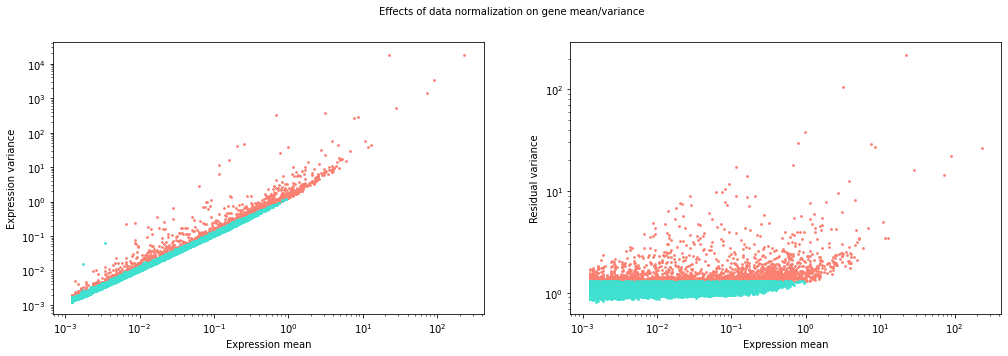

In [18]:
fig, (plt1, plt2) = plt.subplots(ncols = 2, sharex=True, figsize=(17, 5))

# -------------------- #

# Scatter 1 : EXPRESSION
# x : expression mean, y = expression variance
plt1.scatter(x_1_first, y_1_first, color = "salmon", s = 3)
plt1.scatter(x_1_others, y_1_others, color = 'turquoise', s = 3)
# Log scale
plt1.set_xscale("log")
plt1.set_yscale("log")
# Labels
plt1.set_xlabel('Expression mean')
plt1.set_ylabel('Expression variance')

# -------------------- #

# Scatter 2 : RESIDUAL
# x : expression mean, y = residual variance
plt2.scatter(x_2_first, y_2_first, color = "salmon", s = 3)
plt2.scatter(x_2_others, y_2_others, color = 'turquoise', s = 3)
# Log scale
plt2.set_xscale("log")
plt2.set_yscale("log")
# Labels
plt2.set_xlabel('Expression mean')
plt2.set_ylabel('Residual variance')
              
# -------------------- #

# Title, saving

fig.suptitle('Effects of data normalization on gene mean/variance', fontsize=10)
plt.savefig('problem1-normalization.png')
plt.show()

In [19]:
normalization_comments = """
As we said before, we are more interested in genes with high variance (red color - the first 2000 genes), since those genes are expressed in only a subset of cells 
and can work together with other genes to enable specific cell types to perform functions other cells cant.
We are interested in knowing the task of the first 2000 genes -- or, to not have too much work, since 2000 genes is a lot to cover, we would firstly like to know the task of few genes with the highest variance.
Some of the genes, as we can see, have extremely high variance.
"""

### 1.3 Data visualization
Gene expression data, even with gene filtering, is very high-dimensional. Even though we've managed to reduce the number of genes from ~26,000 to only 2,000, that's still way too much to reason about in our minds. One way of finding patterns in the data is to simply look at a visualization. Obviously, we can't visualize a 2,000 dimensional space, so we resort to embedding algorithms, which will try to find a 2D embedding, such that the structure of the 2,000 dimensional space is preserved as much as possible.

Genes generaly exhibit a lot of correlation. This makes sense, since some genes act as inhibitors, while other promote other genes. The interactions between genes are very complex. However, we have methods to deal with correlated data, namely Principal Component Analysis (PCA). Once we run PCA, we get de-correlated feature vectors, and these tend to work better on most methods. However, PCA is a linear dimensionality reduction algorithm, and can't capture much of the intricate structure in the high-dimensional space. We generally reduce the number of features using PCA first, to some number of principal components e.g. 50, then we apply a non-linear embedding algorithm. The two most popular approaches are t-SNE and UMAP. You may use either one of these to generate a 2D embedding. You can play around with the parameters and see how the visualization changes.

1. Run PCA on the residuals of our 2,000 selected genes and reduce the data to 50 principcal components.
2. Run an embedding algorithm of choice, either t-SNE or UMAP on these principal components.
3. Plot the 2D embedding. Create one figure with two subplots and color the data points by cell type, and by the patient status (healthy/COVID). Save the figure into `problem1-visualization.png`.

Do you notice anything interesting?
Here are just a couple questions you might try to answer:
- How well do the colors line up with the visualization clusters?
- You can also visualize the first two components of the PCA embedding. Is there any apparent clustering there?
- How does playing with the parameters affect the visualization?
- Does either t-SNE or UMAP reveal any structure that the other does not?
- How does reducing the number of principal components affect the visualization?

Save your answers into the `visualization_comments` variable.

*Hint*: Use the `openTSNE` or `umap-learn` packages for t-SNE/UMAP embeddings.

**[8 points]**

In [20]:
sc.pp.pca(top_2000_genes, n_comps=50)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


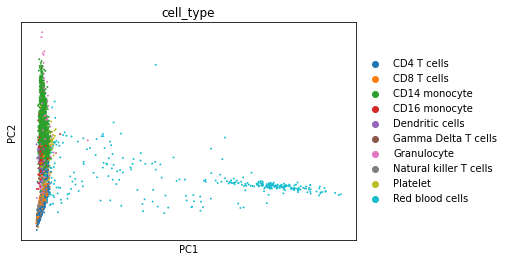

In [21]:
sc.pl.pca(top_2000_genes, color = "cell_type")

In [22]:
# Time
embedding = openTSNE.TSNE(perplexity=60, metric="cosine", exaggeration=1, n_jobs=1).fit(top_2000_genes.obsm["X_pca"])
top_2000_genes.obsm["X_tsne"] = embedding.view(np.ndarray)

In [23]:
colors_ = ['aqua', 'lightgreen', 'pink', 'khaki', 'coral', 'gold', 'salmon', 'lightblue', 'silver', 'orchid']
colors_status_ = ['turquoise', 'salmon']
cell_types = top_2000_genes.obs["cell_type"].unique()
colors = {
    ct: col for ct, col in zip(cell_types, colors_)
}

In [24]:
len(cell_types)

10

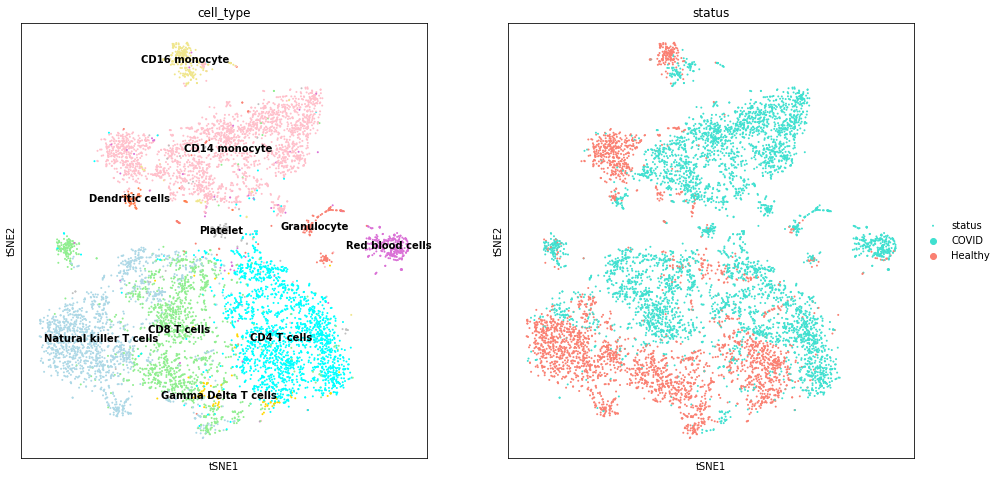

In [25]:
###### Try with parameters perplexity=60 and exaggeration=1

fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
plt1 = sc.pl.tsne(top_2000_genes, color="cell_type", ax=ax[0], size=16, show=False, legend_loc="on data", palette=colors_, label = "cell_type")
plt2 = sc.pl.tsne(top_2000_genes, color="status", ax=ax[1], size=16, show=False, palette = colors_status_, label = "status")

ax[0].set_xlabel('tSNE1')
ax[0].set_ylabel('tSNE2')

ax[1].set_xlabel('tSNE1')
ax[1].set_ylabel('tSNE2')

plt.savefig("problem1-visualization.png")
plt.show()


In [26]:
print(cell_types)

['CD4 T cells', 'CD8 T cells', 'CD14 monocyte', 'Red blood cells', 'Dendritic cells', 'Granulocyte', 'Natural killer T cells', 'CD16 monocyte', 'Gamma Delta T cells', 'Platelet']
Categories (10, object): ['CD4 T cells', 'CD8 T cells', 'CD14 monocyte', 'Red blood cells', ..., 'Natural killer T cells', 'CD16 monocyte', 'Gamma Delta T cells', 'Platelet']


In [27]:
visualization_comments = """
As we can see on the pictures, some cells are more present in healthy individuals and some more in covid infected individuals.
Cells, present mostly in heatlhy individuals are Natural killer T cells and Gamma delta T cells. An on the other hand, Red blood cells, Platelet, 
Granulocyte, CD8 T Cells are more present in healthy donors.
Some cells like CD16 monocyte and CD4 T cells are present in covid infected and healthy donors about the same.
CD14 monocyte is present more in covid infected donors, but they are still present in a sufficiently large percentage in the healthy ones.
"""

## Problem 2: Which genes are *really* important?

We now have a visualization with some pretty obvious clustering structure. The provided cell-types as indicated by the colors correspond quite nicely with the clusters.

However, our work is not done. Before, we selected 2,000 genes which might be interesting, but this doesn't tell us anything about which genes are interesting to a specific cell-type. In this exercise, we will find cell-type specific genes. There are many ways of finding cell-type specific genes, but we will here consider a machine learning approach.

Logistic regression is a linear classification model which has some attractive properties. It's fast. And, because it's lienar, it's also interpretable; to find which features are important for a specific classification task, we need only look at the regression coefficients of the fitted model.

Using logistic regression, we will ask the following question: For every cell-type, which are the genes which are important in differentiating this cell type from all the others. In machine learning terms, for every cell type, we will fit a binary logistic regression model, where we will predict whether or not the cell belongs to the particular cell-type. We will fit these models on the Pearson residual matrix. Then, we can inspect the coefficients of every model. A positive coefficient should indicate that a gene should be expressed in that cell type, while a negative coefficient indicates that a gene should not be expressed. Finally, we selecting a subset of these over-expressed genes according to some criteria, e.g. some threshold on regression coefficients, or we can simply pick the top-K genes.

Then, having obtained a list of interesting genes, it's often a good idea to do a visual check. We can again use our 2D visualization from the previous exercise, but this time coloring the cells by the residual value of that particular gene. A representative gene will be highly expressed in our cell-type of interest, and have low or no expression in other cell-types.

**TASK**:
1. For each cell-type, fit a logistic regression model on all the genes using the residual matrix, predicting whether or not a cell belongs to that particular cell-type.
2. For every cell-type, find the top two over-expressed genes by looking at regression coefficient and plot them using the 2D visualization from the previous exercise. Save your plots into `problem2.png`.

Write down any potential comments into the `finding_important_genes_comments` variable.

*Hint*: we can control the number of genes with nonzero coefficients in two ways. First, we can use the L1 penalty instead of the default L2 penalty, which induces sparse coefficients. This can reduce the number of non-zero coefficients greatly. Secondly, we can increase the regularization strength. If you are having trouble finding representative genes, consider playing around with these.

**[10 points]**

*Hint*: Use `sklearn.linear_model.LogisticRegression`.

In [28]:
# Naredimo logistično regresijo -> method = "logreg"

# Bolj kot je svetle barve, je ta gen bolj prisoten v tej celici oz. je zelo pomemben gen za določeno celico (visok koef)

In [29]:
sc.tl.rank_genes_groups(top_2000_genes, groupby = "cell_type", method = "logreg", max_iter = 1000)

In [30]:
result = top_2000_genes.uns["rank_genes_groups"]
groups = result["names"].dtype.names
df1 = pd.DataFrame({group: result["names"][group] for group in groups}).head(2)
df = df1.melt(var_name = "cell_type", value_name = "gene")
df1.T

,0,1
CD4 T cells,LTB,MT-RNR2
CD8 T cells,CD8A,CCL5
CD14 monocyte,IFI27,S100A8
CD16 monocyte,FCGR3A,CDKN1C
Dendritic cells,CD74,HLA-DRA
Gamma Delta T cells,IL7R,KLRB1
Granulocyte,FCGR3B,CLC
Natural killer T cells,GNLY,PRF1
Platelet,PPBP,ITGA2B
Red blood cells,HBB,HBA2


In [31]:
titles = ["CD4 T cells: LBT", "CD4 T cells: MT-RNR2", 
          "CD8 T cells: CD8A", "CD8 T cells: CCL5",
          "CD14 monocyte: IFI27", "CD14 monocyte: S100A8",
          "CD16 monocyte: FCGR3A", "CD16 monocyte: CDKN1C",
          "Dendritic cells: CD74", "Dendritic cells: HLA-DRA", 
          "Gamma Delta T cells: IL7R", "Gamma Delta T cells: KLRB1",
          "Granulocyte: FCGR3B",  "Granulocyte: CLC",
          "Natural killer T cells: GNLY", "Natural killer T cells: PRF1", 
          "Platelet: PPBP",  "Platelet: ITGA2B", 
          "Red blood cells: HBB",  "Red blood cells: HBA2"]

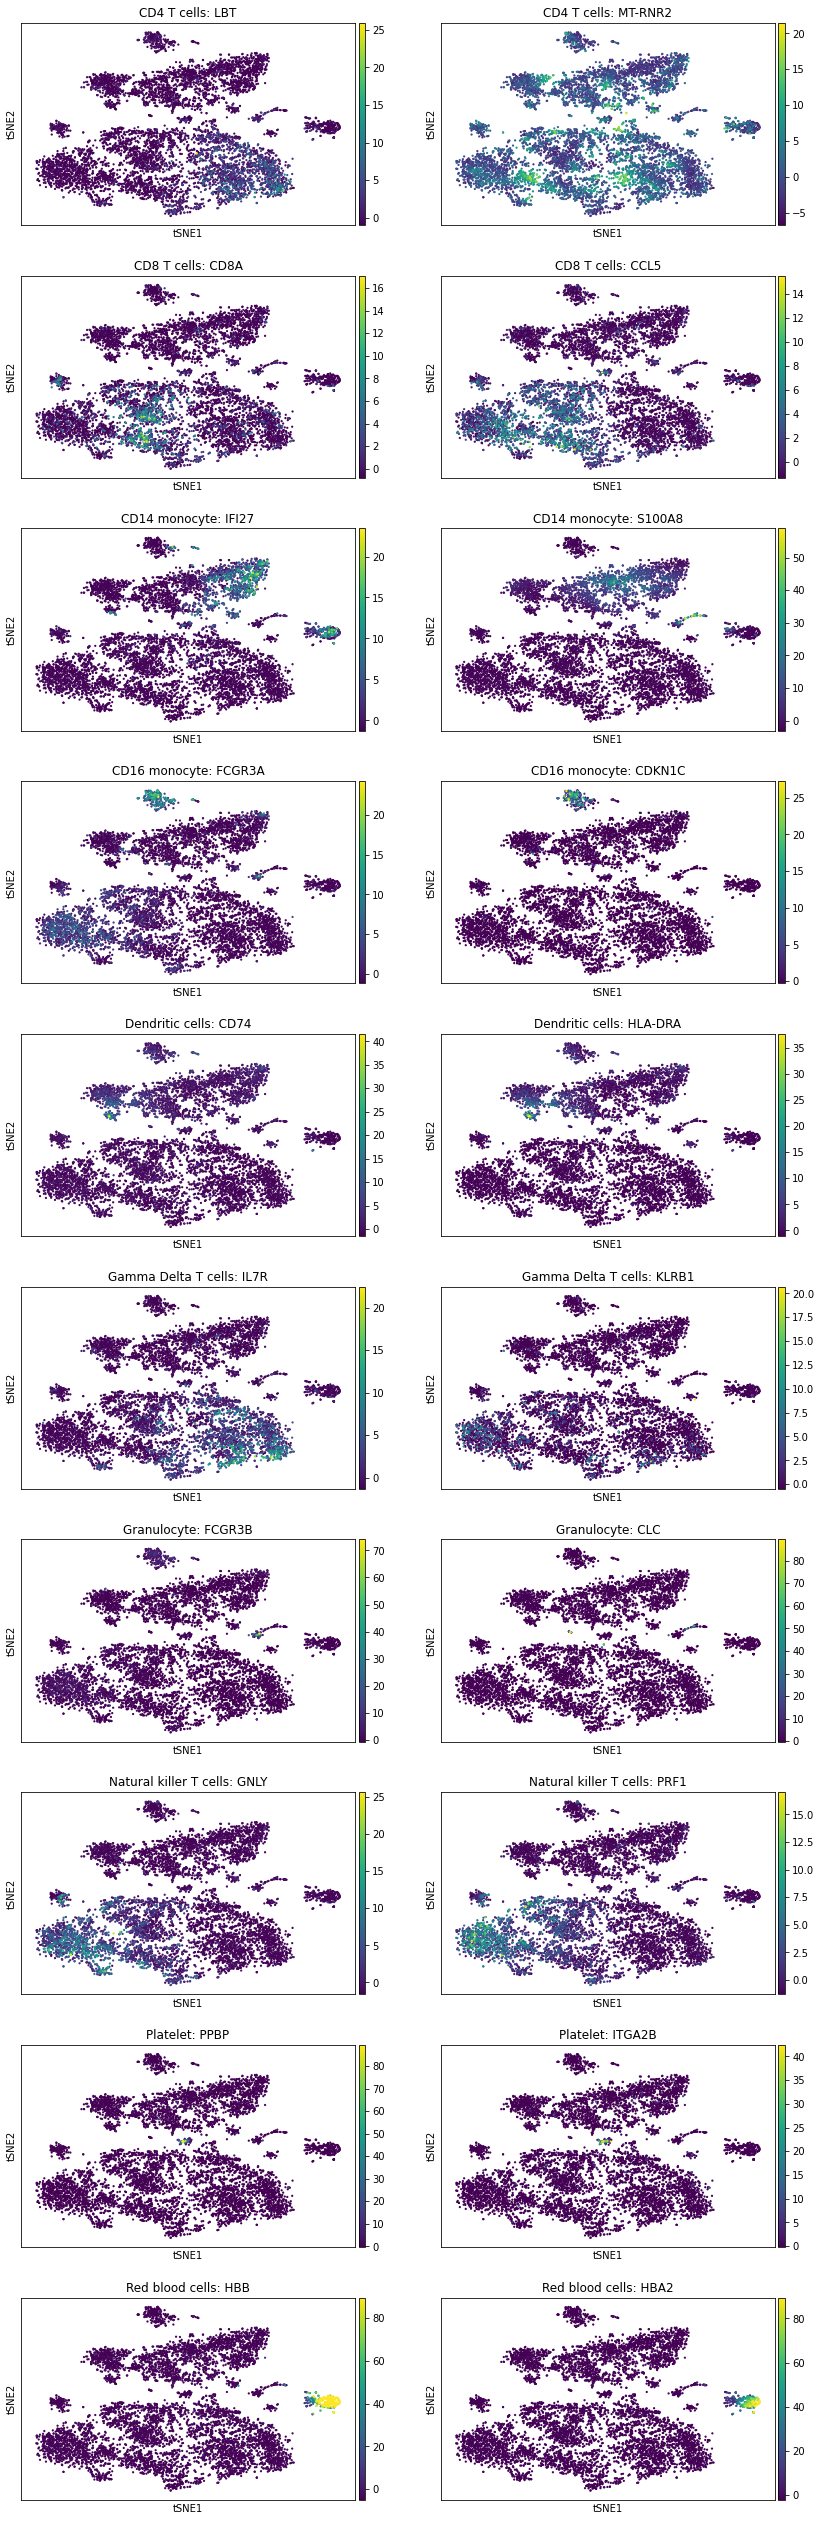

In [32]:
fig = sc.pl.tsne(top_2000_genes, color = df["gene"], size = 20, ncols = 2, title = titles, return_fig = True)

fig.savefig("problem2.png")

In [33]:
finding_important_genes_comments = """
The results are expected, since the color intensities make quite sense.
For example, if we take a look at the first row, we can see that the genes most important for CD4 T cells are LBT and MT-RNR2. 
However, the gene MT-RNR2 is present even in some other cells as the graph is pretty bright colored, 
but it is more important (and maybe more present) gene in the CD4 T cell.
And the same logic goes for other cells and their "assigned" genes.

Therefore, logistic regression not only determine in which cells the genes occur, 
but also assigns some intensity to a presence of a gen in those cells.
So the selected cell for a particular gene does not tell us that the gene is present only in that cell, but tells us that this gene 
has the highest "influence" on that cell function.
"""

## Problem 3: How does COVID-19 affect cell-type composition?

Since we are working with data from a set of COVID patients and healthy donors, it would be interesting to see what effects COVID has on the cells. One quick thing we can look at is the cell-type composition between healthy and sick donors.

**TASK**:
For every donor, calculate the cell-type proportions and plot them in a stacked bar-chart. Save your plots into `problem3.png`. What do you notice? Are there differences in cell-type composition between healthy and sick donors? Write your observations into the `cell_type_composition_comments` variable.

*Hint*: You can take inspiration on how to construct stacked bar-charts from [here](https://python-graph-gallery.com/13-percent-stacked-barplot/).

**[10 points]**

In [34]:
#d = data.obs.groupby(['donor', 'cell_type']).apply(len)
donors = data.obs.groupby(['donor', 'cell_type']).cell_type.agg('count').to_frame('count').reset_index()

In [35]:
types = donors.cell_type.unique()

In [36]:
indexes = donors.donor.unique()

In [37]:
type_count = {}

for t in types:
    type_count[t] = []

In [38]:
for (cell_name, cell_num) in zip(donors["cell_type"], donors["count"]):
    #print(cell_name, cell_num)
    type_count[cell_name].append(cell_num)

In [39]:
type_count_df = pd.DataFrame(type_count)

In [43]:
type_count_df.index = indexes

In [45]:
dfff = type_count_df.transpose()

In [46]:
# Pogledamo delež

for n in dfff.columns:
    proc = (dfff[n] / dfff[n].sum())
    dfff[n] = proc

In [47]:
dfff = dfff.transpose()

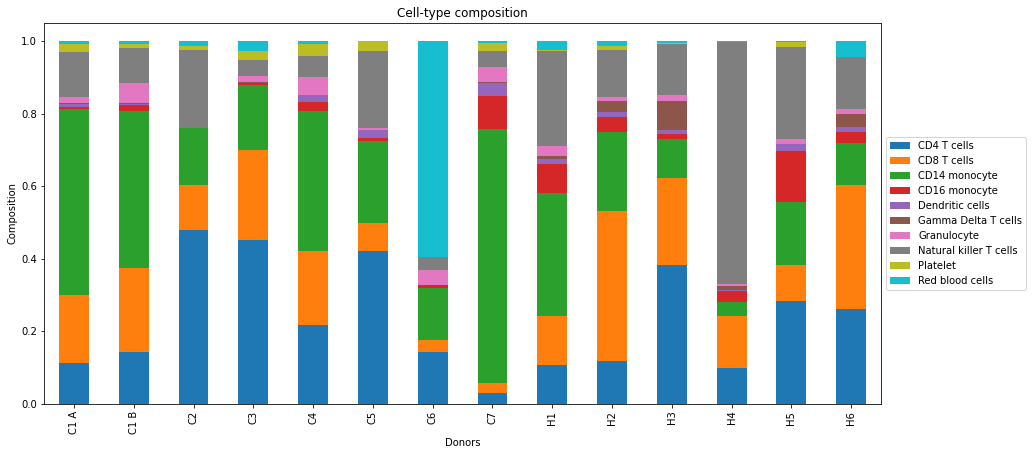

In [48]:
# PLOT : 

ax = dfff.plot(kind = 'bar', stacked = True, figsize = (15, 7), title = "Cell-type composition", legend = False)
lgd = ax.legend(loc = "center left", bbox_to_anchor=(1.0, 0.5))

ax.set_xlabel('Donors')
ax.set_ylabel('Composition')

ax.figure.savefig("problem3.png", bbox_inches = "tight")

In [49]:
cell_type_composition = """
As we can see even in the graphs we made earlier, there are some differences between healthy and sick cells.
In this graph, however, the cell structure of every donor is presented.
We can see that Natural killer T cells are present most in healthy cells and Red blood cells are present more in infected cells.
The most interesting is that Gamma delta T cells are present only in healthy donors' cell structure.
There are some differences in cell composition also between all healthy donors and similar between all donors infected with covid.
It is clear that healthy people do not have exactly the same composition as they are differently resistant to diseases and viruses.
And the same goes for infected people. And also, they could be infected with different mutation of COVID virus.
"""

## Bonus problem: Gene Ontology Enrichment Analysis

In problem 2, we found a number of genes, which are important for a given cell-type. Okay, so now what? We aren't biologists; we don't know what these genes actually do. Gene names by themselves are pretty meaningless to us. Luckily for us, there exists a nice resource which groups sets of genes into functional components. For example, for every process in a cell, there are dozens of genes involved. What if instead of looking at individual genes, we instead look at which of these processes are important for a specific cell-type?

The genes involved with each of these processes is described by a gene set. For this homework, we have prepared a gene gene set from the Gene Ontology (GO) database. Load and parse `goslim_prot_hw5.json`. Each entry in this file contains the GO term identifier e.g. GO:0005813 (you can search for these online to find more information), a short description of the functional group, and a list of genes associated with this functional process.

In this exercise, we will perform a simple variant of gene ontology enrichment analysis based on the hypergeometric statistical test. For every cell-type, we will look at the important genes we identified in Problem 2. Then, we will compare these important genes with each gene set. What is the overlap between the important genes and the genes in the gene set? Intuitively, if a gene-set contains 30 genes, and 29 of these genes are important to our cell-type, then this indicates that, probably, the cell-type performs the function associated with the gene set, and this function is pretty unique to this cell-type.

We have already determined important genes in Problem 2. Instead of selecting the top two important genes, we'll now apply a threshold of 0.1 to our regression coefficients i.e. the important genes are all the genes associated with a regression coefficient >0.1. Then, we will perform a hypergeometric statistical test to obtain a p-value, which will tell us "What is the probability that we observed 29/30 special genes, out of the 100 expressed genes, given that there are 26,000 genes in total" (numbers will vary after filtering). We will not perform any corrections for multiple comparisons here (although you're welcome to do so if you want). We can set a p-value threshold of 0.01, and look at which gene sets are significantly overexpressed for a particular cell-type.

**TASK**:


**a)** In this section, we will only consider the cells from healthy donors in the data set. This way, we will try to understand what makes the cells different from one another without having to worry about how COVID-19 affects the cell. Using the same logistic regression-based approach as before, find the important genes whose coeffients are >0.1. Then for every cell-type and gene set, find the gene sets which are significantly overexpressed in that particular cell type. Use a significance threshold of at least $\alpha = 0.01$. You may lower the threshold if you're finding a very large number of significant gene sets.

For at least three cell types, write down one or more an intersting genes set that you found. Write a sentence or two why these are interesting. Save your answers into the `go_cell_types` variable.

**[5 points]**

*Hint*: You can use `scipy.stats.hypergeom.sf` to obtain the upper-tail hypergeometric p-value.

*Hint*: You will likely find many gene sets, some of which overlap between the cell types. This is completely fine. While a lot of the gene sets will contain descriptions which you may not understand (e.g. I-kappaB/NF-kappaB complex or DNA geometric change), some of the terms should be easily understandable (e.g. oxygen binding or killing of cells of other organism).

In [ ]:
go_cell_types = """
Natural killer T cells:
    I found gene set A which I thought was cool because A is the first letter of the alphabet.
    
CD14 Monocyte:
    Something something something
    
.
.
.

(please replace all of the above with your own answers)
"""

**b)** Repeat this same process, but this time finding significant gene sets for cell type, look for differences between cells from healthy donors and donors sick with COVID-19.

Save your answers into the `go_covid` variable.

**[5 points]**

In [ ]:
go_covid = """
Healthy:
    ...
    
COVID-19:
    ...
"""